#### Example how to read the data in MNE-python 


In [264]:
import mne
import numpy as np
import matplotlib as plt
from scipy.io import loadmat 
import pandas as pd

%matplotlib qt

In [305]:
fname_mat = 's07.mat'
Data = loadmat(fname_mat)

In [306]:
# Motor Execution
EEG_ME_Left = Data['eeg']['movement_left'][0][0]/1000000
EEG_ME_Right = Data['eeg']['movement_right'][0][0]/1000000
ME_Event = Data['eeg']['movement_event'][0][0]

In [307]:
# Motor Imagery
EEG_MI_Left = Data['eeg']['imagery_left'][0][0]/1000000
EEG_MI_Right = Data['eeg']['imagery_right'][0][0]/1000000
MI_Event = Data['eeg']['imagery_event'][0][0]

In [308]:
# Resting State
RS = Data['eeg']['rest'][0][0]

# Blinking - Noise1
Noise1 = Data['eeg']['noise'][0][0][0][0]

# eyeball up-down - Noise2
Noise2 = Data['eeg']['noise'][0][0][1][0]

# eyeball left-right - Noise3
Noise3 = Data['eeg']['noise'][0][0][2][0]

# head movement - Noise4
Noise4 = Data['eeg']['noise'][0][0][3][0]

# jaw clenching - Noise5
Noise5 = Data['eeg']['noise'][0][0][4][0]




In [309]:
#General Info
sfreq = Data['eeg']['srate'][0][0][0][0] #Sampling Frequency
psenloc = Data['eeg']['psenloc'][0][0] #Sensor location projected to unit sphere
senloc = Data['eeg']['senloc'][0][0] #Sensor locations 3D
bad_trial_indices_voltage = Data['eeg']['bad_trial_indices'][0][0][0][0][0][0][0] #Bad trials indices voltage
bad_trial_indices_mi = Data['eeg']['bad_trial_indices'][0][0][0][0][0][0][1] #Bad trials indices MI
names_types = pd.read_excel(r'ch_names&types.xlsx') #Read file with ch names and types
ch_types = names_types['ch_types'].tolist() #ch_types
ch_names = names_types['ch_names'].tolist() #ch_names


In [311]:
# Create stimuli channel
Noise1_Event = np.zeros((1,Noise1.shape[1]))
Noise1_Event[0,0] = 1
Noise2_Event = np.zeros((1,Noise2.shape[1]))
Noise2_Event[0,0] = 2
Noise3_Event = np.zeros((1,Noise3.shape[1]))
Noise3_Event[0,0] = 3
Noise4_Event = np.zeros((1,Noise4.shape[1]))
Noise4_Event[0,0] = 4
Noise5_Event = np.zeros((1,Noise5.shape[1]))
Noise5_Event[0,0] = 5
RS_Event = np.zeros((1,RS.shape[1]))
RS_Event[0,0] = 6
ME_Event_Rigth = ME_Event * 7
ME_Event_Left = ME_Event * 8
MI_Event_Rigth = MI_Event * 9
MI_Event_Left = MI_Event * 10

# Join All Events and create stimuli channels
#Event_Stimuli = np.concatenate((Noise1_Event, Noise2_Event, Noise3_Event, Noise4_Event, Noise5_Event, RS_Event, ME_Event_Rigth, ME_Event_Left, MI_Event_Rigth, MI_Event_Left), axis=1)
Event_Stimuli = np.concatenate((ME_Event_Rigth, ME_Event_Left, MI_Event_Rigth, MI_Event_Left), axis=1)

In [312]:
# Create raw data
#Chs_Data = np.concatenate((Noise1, Noise2, Noise3, Noise4, Noise5, RS, EEG_ME_Right, EEG_ME_Left, EEG_MI_Right, EEG_MI_Left), axis=1)
Chs_Data = np.concatenate((EEG_ME_Right, EEG_ME_Left, EEG_MI_Right, EEG_MI_Left), axis=1)

In [313]:
# Event ID definition
#event_id = {'Blink':1,'Up/Down':2,'Left/Right':3,'Jaw':4,'HeadMov':5, 'Resting':6, 'ME_Right':7, 'ME_Left':8, 'MI_Right':9, 'MI_Left':10}
event_id = {'ME_Right':7, 'ME_Left':8, 'MI_Right':9, 'MI_Left':10}

In [314]:
# Create Info
info = mne.create_info(ch_names, sfreq, ch_types)


In [315]:
# Create a montage based on the electrode positions
SensorLoc = dict(zip(ch_names[0:64], senloc.tolist()))
montage = mne.channels.make_dig_montage(ch_pos=SensorLoc, coord_frame='head')

# Include the montage in the info
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EMG, 1 Stimulus
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 69
 projs: []
 sfreq: 512.0 Hz
>

In [316]:
# Create raw object
Raw_Data = np.concatenate((Chs_Data,Event_Stimuli), axis=0) 
raw = mne.io.RawArray(Raw_Data, info)

# Read events from Stimuli channel
events = mne.find_events(raw, stim_channel='Stim', verbose=True,initial_event=True)

Creating RawArray with float64 data, n_channels=69, n_times=1003520
    Range : 0 ... 1003519 =      0.000 ...  1959.998 secs
Ready.
280 events found
Event IDs: [ 7  8  9 10]


In [317]:
# Plot Data
raw.plot(events=events,event_id=event_id)

Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [318]:
# Only imaginary events
event_id_M = {'ME_Right':7, 'ME_Left':8, 'MI_Right':9, 'MI_Left':10}
events_M = events[events[:,2] > 6]


In [319]:
# Plot Raw Data only with Movements
raw.plot(events=events_M,event_id=event_id_M)

Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


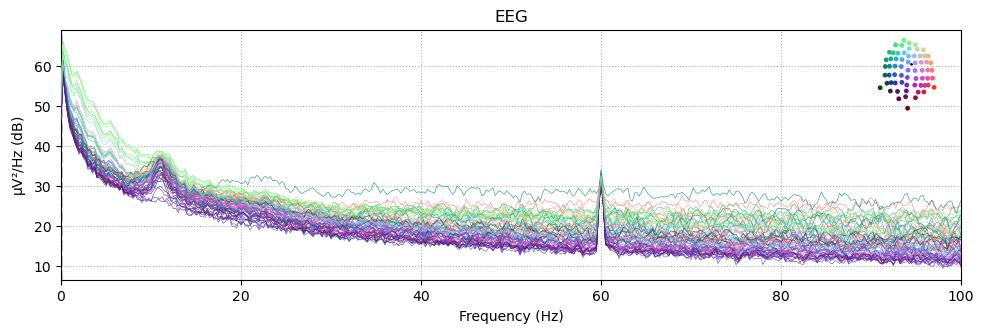

In [279]:
# Take a segment and plot the psd of the raw data
raw.copy().crop(500,800).plot_psd(fmax=100)

In [320]:
biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(biosemi64_montage)

<RawArray | 69 x 1003520 (1960.0 s), ~528.4 MB, data loaded>

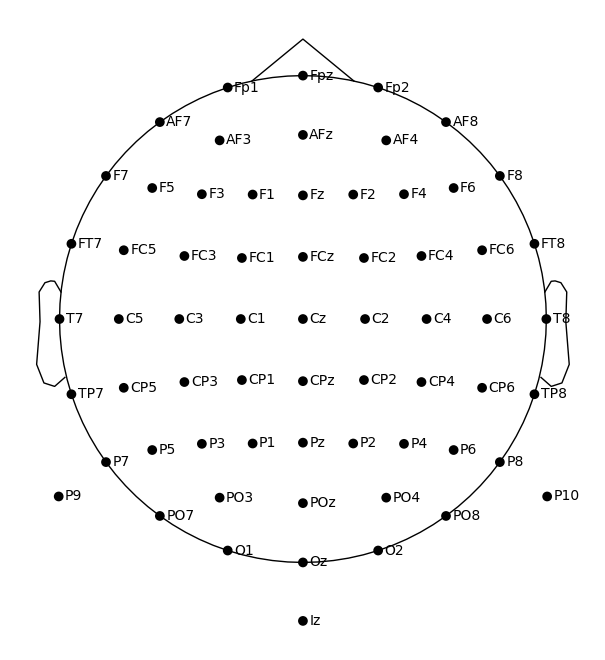

In [321]:
# As the 2D plot looks strange, we can modifi the sphere by adding sphere='eeglab'
raw.plot_sensors(kind='topomap',ch_type='eeg', show_names=True, sphere='eeglab')

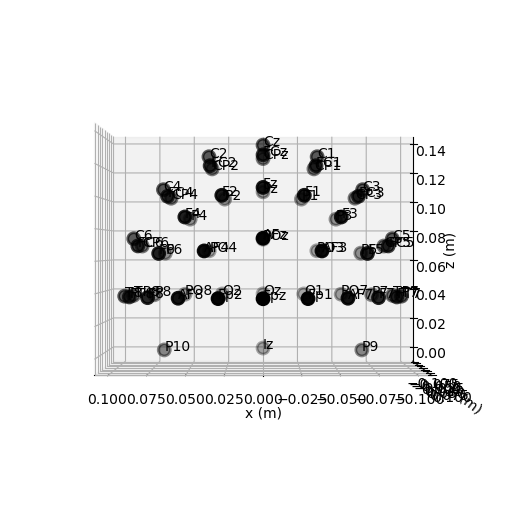

In [322]:
#Lets visualize in 3D to see if they are ok
raw.plot_sensors(kind='3d',ch_type='eeg', show_names=True)

In [323]:
# Create Epochs
#epochs = mne.Epochs(raw, events_M, event_id_M, tmin=-1.5, tmax=4, picks=("C3", "Cz", "C4"), baseline=None, preload=True)
epochs = mne.Epochs(raw, events_M, event_id_M, tmin=-1.95, tmax=4.95, picks=('eeg'), baseline=None, preload=True)
epochs.filter(0.5, 45)

Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 280 events and 3533 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 17920 out of 17920 | elapsed:    8.5s finished


Number of events,280
Events,ME_Left: 20ME_Right: 20MI_Left: 120MI_Right: 120
Time range,-1.949 – 4.949 sec
Baseline,off


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


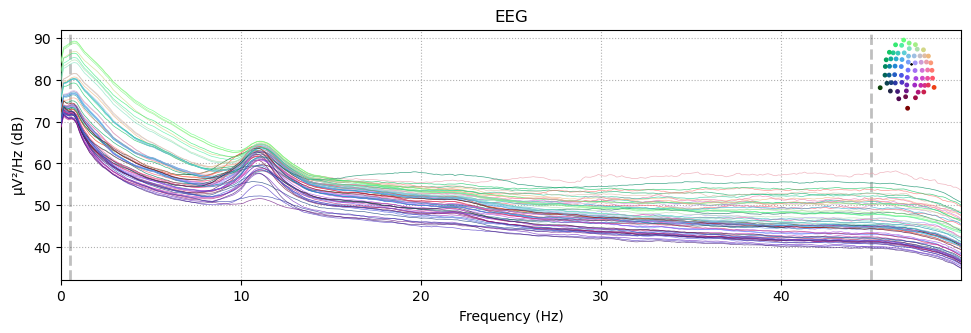

In [281]:
#Plot PSD of the epochs to confirm
epochs.plot_psd(fmax=50)

#### Applying ICA to epochs

In [324]:
#Defining ICA
ica = mne.preprocessing.ICA(n_components=40, max_iter="auto", random_state=97)

#Fit ICA to the epochs
ica.fit(epochs)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 40 components
Fitting ICA took 53.0s.


Method,fastica
Fit,43 iterations on epochs (989240 samples)
ICA components,40
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [325]:
# Plot a topography map of the components
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x967 with 20 Axes>]

In [326]:
# Plot the time courses of the source separation (sources in ICA does not mean brain sources)
ica.plot_sources(epochs, show_scrollbars=False)

Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated


In [327]:
# Plot the properties of particular components
components = [i for i in range(0, 40)]
ica.plot_properties(epochs,components)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 pro

c:\Users\andresfs\.conda\envs\mneUp\lib\site-packages\mne\viz\ica.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, facecolor=[0.95] * 3)


Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching eve

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6

In [328]:
# Exclude components 0 and 6
ica.exclude = [0, 2,7,13,15,16,38] # This is decided manuallyt after analyzing the components

In [329]:
#Apply ICA to the data
ica.apply(epochs)

Applying ICA to Epochs instance


    Transforming to ICA space (40 components)
    Zeroing out 7 ICA components
    Projecting back using 64 PCA components


Number of events,280
Events,ME_Left: 20ME_Right: 20MI_Left: 120MI_Right: 120
Time range,-1.949 – 4.949 sec
Baseline,off


In [338]:
# Compute TF Maps - Multitaper
freqs = np.arange(3, 35.5, 0.5)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power_MI_R = mne.time_frequency.tfr_multitaper(epochs['MI_Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)
power_MI_L = mne.time_frequency.tfr_multitaper(epochs['MI_Left'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:   54.8s finished


Not setting metadata


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:  1.1min finished


Not setting metadata


In [340]:
# Compute TF Maps - Wavelet
freqs = np.arange(3, 35)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power_MI_R = mne.time_frequency.tfr_morlet(epochs['MI_Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)
power_MI_L = mne.time_frequency.tfr_morlet(epochs['MI_Left'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    9.2s finished


Not setting metadata


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    9.1s finished


Not setting metadata


In [354]:
# Plotting TF
baseline = (-0.5,0)
mode = 'percent'
#mode = 'mean'
vmin=-2.5
vmax=2.5
#vmin=None
#vmax=None
fmin = 5 
fmax = 28
cmap = 'jet'
channels = ['C3','C4']
for channel in channels:
    power_MI_R.average().plot(picks=channel, baseline=baseline, mode=mode ,vmin=vmin, vmax=vmax, fmin=fmin, fmax=fmax, cmap=cmap, title=channel+ ' - Right')
    power_MI_L.average().plot(picks=channel, baseline=baseline, mode=mode ,vmin=vmin, vmax=vmax, fmin=fmin, fmax=fmax, cmap=cmap, title=channel+ ' - Left')
    #power_contrast.plot(picks=channel, baseline=baseline, mode=mode ,vmin=vmin, vmax=vmax, fmin=fmin, fmax=fmax, cmap=cmap, title=channel+ ' - Contrast')

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


Applying baseline correction (mode: mean)


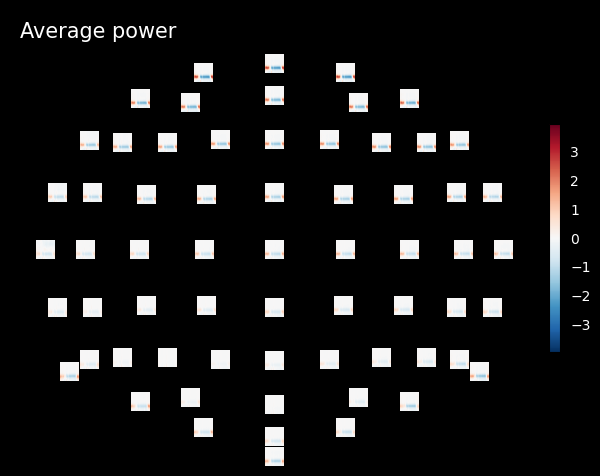

c:\Users\andresfs\.conda\envs\mneUp\lib\site-packages\matplotlib\cbook\__init__.py:307: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
c:\Users\andresfs\.conda\envs\mneUp\lib\site-packages\matplotlib\cbook\__init__.py:307: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
c:\Users\andresfs\.conda\envs\mneUp\lib\site-packages\matplotlib\cbook\__init__.py:307: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
c:\Users\andresfs\.conda\envs\mneUp\lib\site-packages\matplotlib\cbook\__init__.py:307: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
c:\Users\andresfs\.conda\envs\mneUp\lib\site-packages\matplotlib\cbook\__init__.py:307: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
c:\Users\andresfs\.conda\envs\mneUp\lib\site-packages\matplotlib\cbook\__init__.py:307: RuntimeWarning: `mask` is None, not adding cont

In [349]:
power_MI_R.average().plot_topo(baseline=(-0.5, 0.5), mode="mean", title="Average power",fmin=fmin, fmax=fmax)

In [285]:
error

NameError: name 'error' is not defined

In [294]:
power_contrast = mne.combine_evoked((power_MI_R,power_MI_L),(-1,1))

AttributeError: 'EpochsTFR' object has no attribute 'nave'

In [ ]:
power_contrast = mne.combine_evoked((power_MI_R,power_MI_L))

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 170.7 Hz
>

In [ ]:
freqs = np.arange(2, 30)
power_MI_L =  mne.time_frequency.tfr_morlet(epochs['MI_Left'],freqs=freqs,n_cycles= 3, return_itc=False)
channels = ['CP3','C4']
for channel in channels:
    power_MI_L.plot(picks=channel,baseline=(-1.5, 0),title=channel+ ' - Left') #baseline=(-0.5, 0), mode='percent',vmin=-1, vmax=1,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   48.0s finished


In [ ]:
freqs = np.arange(2, 30)
power_MI_R =  mne.time_frequency.tfr_morlet(epochs['MI_Right'],freqs=freqs,n_cycles= 3, return_itc=False)
channels = ['C3','C4']
for channel in channels:
    power_MI_R.plot(picks=channel,baseline=(-1.5, 0),vmin=-4e-8, vmax=4e-8,title=channel+ ' - Right') #baseline=(-0.5, 0), mode='percent',vmin=-1, vmax=1,

Applying baseline correction (mode: mean)


Applying baseline correction (mode: mean)


In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    epochs['MI_Left'],
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.8s finished


Applying baseline correction (mode: percent)


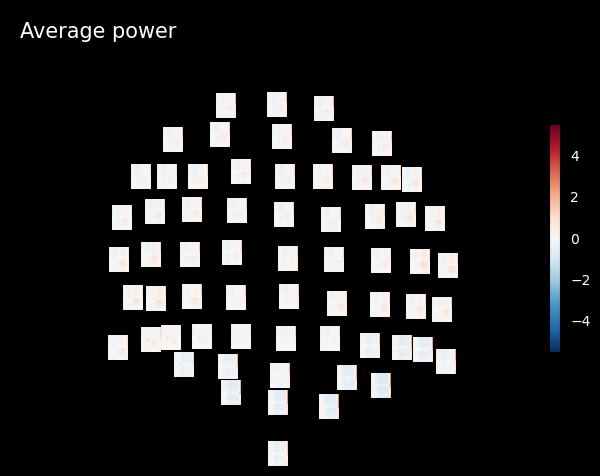

In [ ]:
power.plot_topo(baseline=(-1.5, 0), mode="percent", title="Average power")

In [ ]:
power.plot(picks=['C3','C4'], baseline=(-0.5, 0), mode='percent',vmin=-1, vmax=1)

Applying baseline correction (mode: percent)


[<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 2 Axes>]

In [ ]:
from matplotlib.colors import TwoSlopeNorm

freqs = np.arange(2, 36)  # frequencies from 2-35Hz
#vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1.5, 0)  # baseline interval (in s)
#cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS


In [ ]:
power = mne.time_frequency.tfr_multitaper(epochs['MI_Left'], freqs=freqs, n_cycles=freqs, use_fft=True, picks=['C3'], return_itc=False, decim=2, average=True)
power.apply_baseline(baseline)

#power, _ = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=1)

In [ ]:
freqs = np.arange(5.0, 100.0, 3.0)
vmin, vmax = -3.0, 3.0  # Define our color limits.

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for n_cycles, time_bandwidth, ax, title in zip(
    [freqs / 2, freqs, freqs / 2],  # number of cycles
    [2.0, 4.0, 8.0],  # time bandwidth
    axs,
    [
        "Sim: Least smoothing, most variance",
        "Sim: Less frequency smoothing,\nmore time smoothing",
        "Sim: Less time smoothing,\nmore frequency smoothing",
    ],
):
    power = mne.time_frequency.tfr_multitaper(
        epochs,
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=time_bandwidth,
        return_itc=False,
    )
    ax.set_title(title)
    # Plot results. Baseline correct based on first 100 ms.
    power.plot(
        [0],
        baseline=(0.0, 0.1),
        mode="mean",
        vmin=vmin,
        vmax=vmax,
        axes=ax,
        show=False,
        colorbar=False,
    )
plt.tight_layout()

In [ ]:

    # Plot results. Baseline correct based on first 100 ms.
tfr.plot(
    epochs[MI_Left],
    baseline=(-1.5,0),
    mode="mean",
    axes=ax,
    show=False,
    colorbar=False,
)
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_1samp_test as pcluster_test

tfr.apply_baseline(baseline, mode="percent")


###### Coments

In [ ]:
# Check this for importing the current electrode montage: https://mne.tools/stable/generated/mne.channels.make_dig_montage.html#mne.channels.make_dig_montage
#mne.channels.make_dig_montage(ch_pos=senloc, coord_frame='head')
